# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime

### **Import Data**

In [283]:
df = pd.read_csv('../data/train.csv')

In [284]:
df_models = pd.read_csv('../data/car_models.csv')

---

### **Data Understanding**

In [285]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [286]:
df.describe(include='all')

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74452,74456,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,72,735,NaN,NaN,40,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,Focus,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14808,6353,NaN,NaN,38050,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,2017.096611,16881.889553,NaN,23004.184088,NaN,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,NaN,NaN,2.208704,9736.926322,NaN,22129.788366,NaN,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,NaN,NaN,1970.000000,450.000000,NaN,-58540.574478,NaN,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,NaN,NaN,2016.000000,10200.000000,NaN,7423.250000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,2017.000000,14699.000000,NaN,17300.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,2019.000000,20950.000000,NaN,32427.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


#### **Data Quality**
- **Price**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a slightly left skewed distribution
- **Mileage**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a left skewed distribution, we also have negative values, so we need to handle these values
- **Tax**: we have negative values, we need to investigate why these values are negative and If they make any sense in this context
- **MPG**: We have negative values, we need to handle these values
- **Engine Size**: We have negative values, needing to handle them
- **PaintQuality%**: We have values above 100%, we need to check this cases and see if they make any kind of sense
- **previousOwners**: We have negative and float values, we need to handle this cases as well
- **hasDamage**: Seems like a constant value feature, we need to check if thats the case


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [288]:
df['transmission'].unique()

array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

In [289]:
df['fuelType'].unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

we have lots of typos in here, we need to fix this later on

---

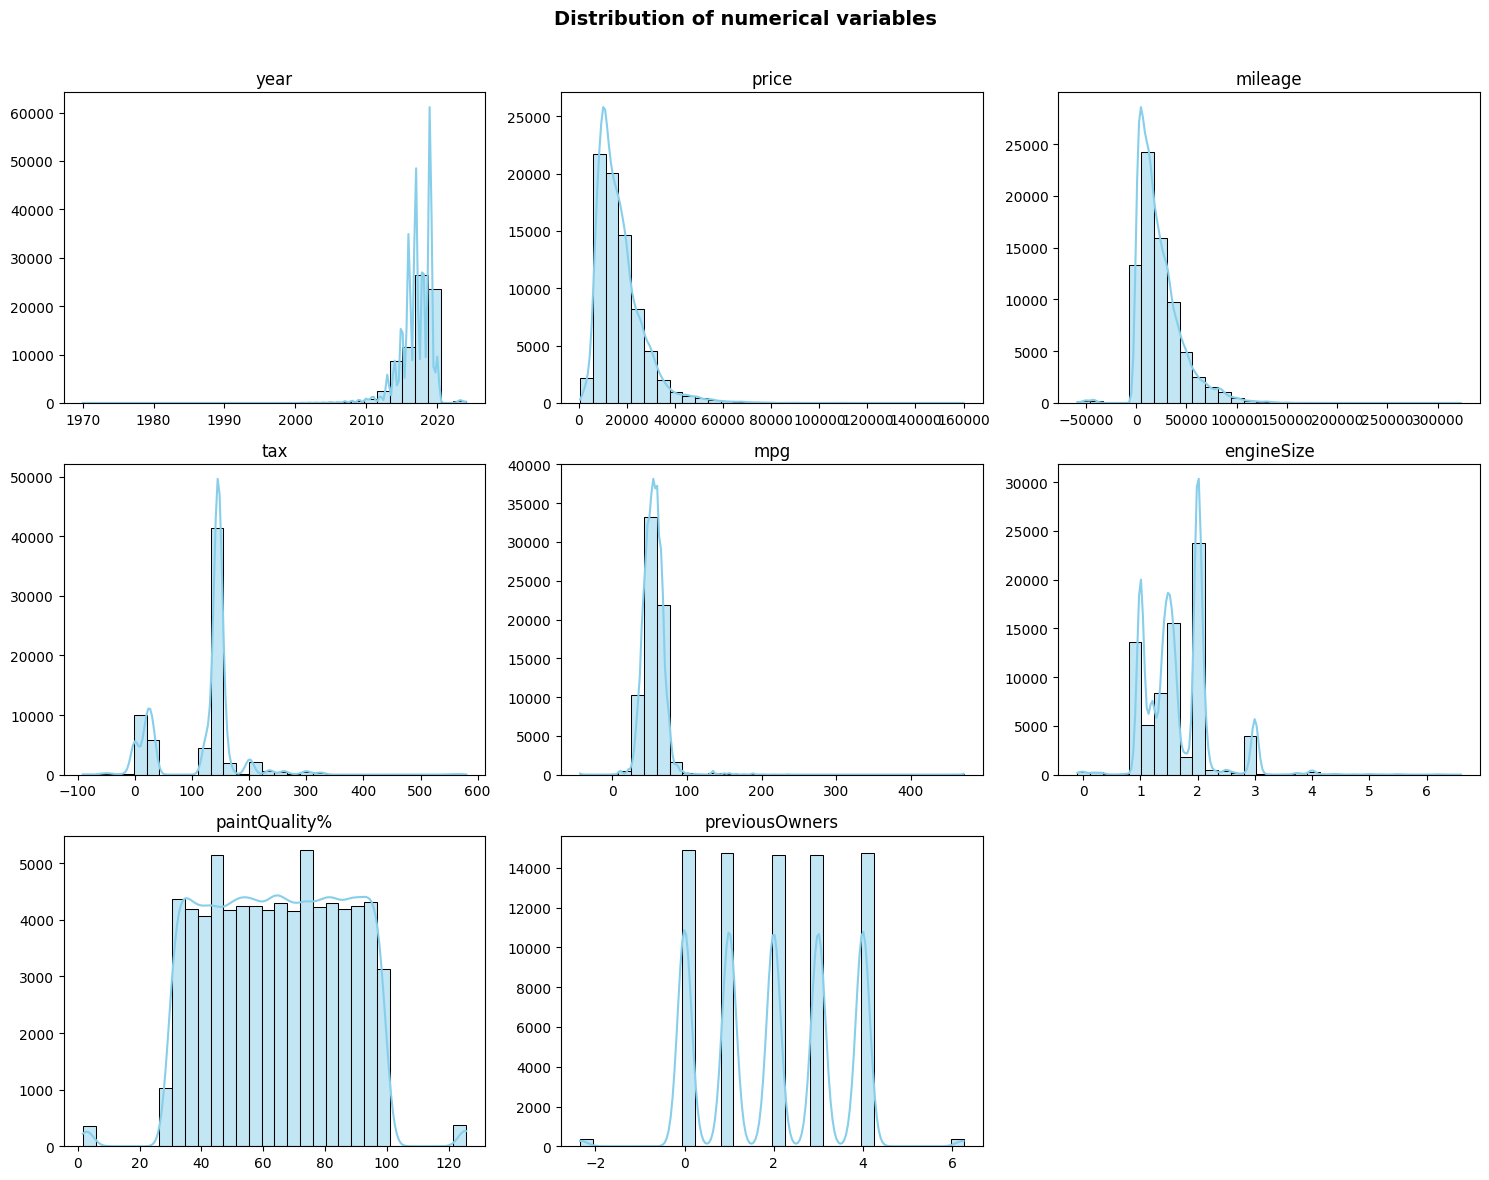

In [290]:
num_cols = [c for c in ['year','price','mileage','tax','mpg','engineSize','paintQuality%','previousOwners'] if c in df.columns]

n = len(num_cols)
ncols = 3  # number of graphics per row
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

#remove empty axes (if number of plots is not a multiple of ncols)--» otherwise there would be an empty graph in the third line
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of numerical variables", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

| Variable | Distribution | Key Range | Insights |
|----------|--------------|-----------|--------------|
| **Year** | Peaked around recent years | 2000-2024<br>*(Mostly 2016-2020)* | Modern cars dominate<br>Create "age" feature for depreciation |
| **Price** | Right-skewed | €500 - €160k<br>*(Mostly 10k-€20k€)* | Log transformation <br>High-end outliers present |
| **Mileage** | Right-skewed | 0 - 300k km<br>*(Mostly 0-40k km)* | Negative correlation with price expected<br>Logical after cleaning |
| **Tax** | Highly right-skewed | 0 - 600<br>*(Mostly 150-200)* | Validate low/zero values<br>Standard tax brackets dominate |
| **MPG** | Right-skewed | 0 - 450<br>*(Mostly 40-80 MPG)* | Extreme values likely errors<br>Log transformation could help |
| **Engine Size** | Multiple peaks | 0 - 6.5L<br>*(Peaks at 1.0, 1.6, 2.0L)* | Positive price correlation expected<br>Reflects vehicle class mix |
| **Paint Quality** | Nearly uniform | 0 - 120<br>*(Expected 0-100)* | Limited predictive power<br>Values >100 likely errors |
| **Previous Owners** | Discrete, multi-peaked | 0 - 6<br>*(Mostly 0-4)* | More owners may lower price<br>Effect likely moderate |

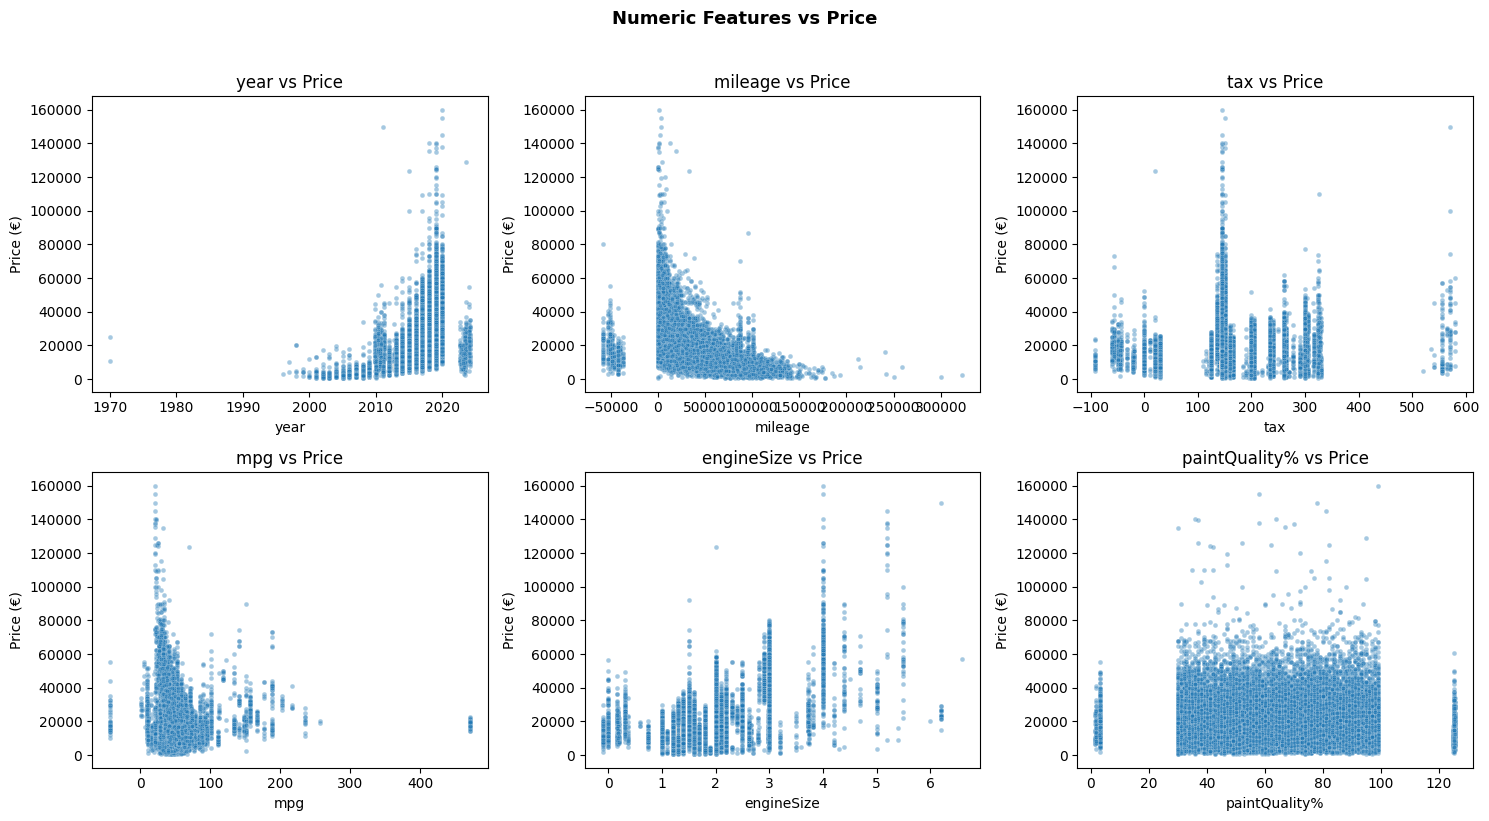

<Figure size 640x480 with 0 Axes>

In [291]:
# List of the numerical features
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']

# Scatterplots for all the numerical features except "previous_owners" because it doesn´t make sense to use scaterplott in this variable
others = [c for c in num_cols if c not in ['price', 'previousOwners']]
n, ncols = len(others), 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, others):
    sns.scatterplot(data=df, x=col, y='price', alpha=0.4, s=12, ax=ax)
    ax.set_title(f"{col} vs Price")
    ax.set_xlabel(col)
    ax.set_ylabel("Price (€)")

# Remove eixos vazios se existirem
for j in range(len(others), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric Features vs Price", y=1.02, fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
plt.tight_layout(); plt.show()

| Feature vs Price | Relationship | Key Pattern 
|------------------|--------------|-------------|
| **Year → Price** | Strong positive | Newer cars are more expensive; vertical banding by year feature |
| **Mileage → Price** | Strong negative | Non-linear: steep drop at low mileage, flattens later curve |
| **Engine Size → Price** | Positive but noisy | Vertical stripes at common sizes (1.0, 1.6, 2.0L) |
| **MPG → Price** | Weak/ambiguous | Hints of negative trend; efficient cars often cheaper |
| **Tax → Price** | No clear trend | Clusters in regulatory bands |
| **Paint Quality → Price** | No visible trend | Near-uniform vertical spread |

---

## **Data Preparation**

#### **Checking for constant value features**

In [292]:
# check for constant values features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')

Constant features: ['hasDamage']


Since hasDamage is a constant feature, we can safely remove it since theres no meaning if its keeped

In [293]:
df= df.drop(columns='hasDamage')

### **Modify Classes**

as we said earlier, we will set the 'other' value in transmission to NaN  
and also we will merge 'hybrid' and 'eletric' into 'other'

In [294]:
# set 'other' value in transmission to NaN
df['transmission'] = df['transmission'].replace('other', np.nan)

# merge 'hybrid' and 'eletric' into 'other'
df['transmission'] = df['transmission'].replace(['hybrid', 'electric'], 'other')

#### **Dealing with missing values**

First, lets check if we have any entries with every feature missing

In [295]:
# create a mask for rows where all columns except 'carID' and 'price' are NaN
mask = df.drop(columns=['carID', 'price']).isna().all(axis=1)
df_missing_rows = df[mask]

df_missing_rows.size

0

We don't have any row that is completely null

##### **Let's now check the percentages of missing values for each column**

In [296]:
# check the percentage of missing values for each column
missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
df_missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percent': missing_percent.values})
df_missing_percent

,column,missing_percent
0,mpg,10.432654
1,tax,10.403696
2,previousOwners,2.040198
3,paintQuality%,2.005976
4,transmission,2.003343
5,Brand,2.002027
6,model,1.996762
7,engineSize,1.995446
8,fuelType,1.988864
9,year,1.962539


We have some percentage of missing values but nothing too bad.

#### **Fill Missing Values in Numeric Features**

For the numeric features, we will use KNN imputation with the 5 nearest neighbors and just set the weights to 'uniform'.

In [297]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [298]:
# store mean and std
means = df[num_cols].mean()
stds = df[num_cols].std()

# normalize
df_scaled = (df[num_cols] - means) / stds

# impute on scaled data
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=num_cols,
    index=df.index
)

# inverse transform
df[num_cols] = df_imputed_scaled * stds + means

#### **Fill Missing Values in Categorical Features**

For the categorical variables we will use a Random Forest Classifier.  
We will train this RFC with the non null entries and use them to predict the null entries.  
We will do this sequentially in this order:  
Brand -> Model -> fuelType -> transmission

Since we believe thats the feature importance order.

In [299]:
def impute_categorical_rfc(df, target_col, ignore_cols=['carID', 'price'], n_estimators=200):
    """
    Impute missing values in a categorical column using a Random Forest Classifier.

    Parameters:
        df (pd.DataFrame): The dataframe containing missing values.
        target_col (str): Column to impute.
        ignore_cols (list): Columns to exclude from predictors.
        n_estimators (int): Number of trees for the Random Forest.

    Returns:
        pd.DataFrame: DataFrame with imputed column.
    """
    #split into rows with and without missing target
    df_notnull = df[df[target_col].notnull()]
    df_null = df[df[target_col].isnull()]

    #print(df_null.head())
    
    # predictors: list of all columns except target and ignored ones
    predictors = df.columns.drop([target_col] + ignore_cols)
    #print(predictors)
    
    #encode predictors, creates a column for every value of the target col and sets True/False for each row
    X_train = pd.get_dummies(df_notnull[predictors], drop_first=True)
    print(X_train)
    y_train = df_notnull[target_col]
    
    # train RFC
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    # predict missing
    if not df_null.empty:
        X_null = pd.get_dummies(df_null[predictors], drop_first=True)
        # we need to reindex the columns of X_null so we have the same columns as X_train
        # if therese a column in X_train that is not in X_null, we fill it with 0
        # if theres a column in X_null that is not in X_train, it will random guess
        X_null = X_null.reindex(columns=X_train.columns, fill_value=0)
        
        df.loc[df[target_col].isnull(), target_col] = rfc.predict(X_null)
    
    print(f"Imputed '{target_col}' using Random Forest with {len(X_train)} training rows.")
    return df

In [300]:
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

for col in cat_cols:
    df = impute_categorical_rfc(df, col)


         year  mileage         tax        mpg  engineSize  paintQuality%  \
0      2016.0  28421.0  102.333851  11.417268         2.0           63.0   
1      2019.0   4589.0  145.000000  47.900000         1.5           50.0   
2      2019.0   3624.0  145.000000  40.900000         1.5           56.0   
3      2018.0   9102.0  145.000000  65.700000         1.0           50.0   
4      2019.0   1000.0  145.000000  42.800000         1.5           97.0   
...       ...      ...         ...        ...         ...            ...   
75968  2015.0  14480.0  125.000000  53.300000         2.0           78.0   
75969  2013.0  52134.0  200.000000  47.900000         2.0           38.0   
75970  2017.0  11304.0  145.000000  67.000000         1.0           57.0   
75971  2015.0  69072.0  125.000000  60.100000         2.0           74.0   
75972  2018.0  16709.0  145.000000  64.200000         1.1           38.0   

       previousOwners  model_ 1 SERIES  model_ 1 Serie  model_ 1 Series  ...  \
0      

In [301]:
# save the filled dataframe to a csv file
#df.to_csv('../data/filled_cars.csv', index=False)

In [302]:
df = pd.read_csv('../data/filled_cars.csv')

---

### **Data Consistency**

In [303]:
#We noticed that some values of paintQuality% are higher than 100%, so we decided to assume that it's value is 100%
df.loc[df['paintQuality%'] > 100, 'paintQuality%'] = 100

In [304]:
columns_negative= ["previousOwners","mileage","mpg","engineSize","tax"]

# Apply abs function to each column in columns_negative
for col in columns_negative:
    df[col] = df[col].abs()

In [305]:
df[['mileage','paintQuality%','year','previousOwners']] = (
    df[['mileage','paintQuality%','year','previousOwners']]
    .round()
    .astype('Int64')
)

In [306]:
df[['tax', 'mpg']] = df[['tax', 'mpg']].round(2)

**fixing brand and model typos**

In [307]:
# normalize strings: strip, lower
def clean_text(s):
    if pd.isna(s):
        return ''
    return str(s).strip().lower()

# normalize
df['brand_clean'] = df['Brand'].apply(clean_text)
df['model_clean'] = df['model'].apply(clean_text)
df_models['brand_clean'] = df_models['brand'].apply(clean_text)
df_models['model_clean'] = df_models['model'].apply(clean_text)
#print('Unique values for brand', df_models['brand_clean'].unique())


# --- fix models ---
def correct_model(row, df_models):
    model = row['model_clean']
    brand = row['brand_clean']
    
    if ((df_models['brand_clean'] == brand) & (df_models['model_clean'] == model)).any():
        return model
    
    if brand in df_models['brand_clean'].values:
        possible_models = df_models[df_models['brand_clean']==brand]['model_clean'].tolist()
        matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
        return matched_model if score >= 40 else model
    
    possible_models = df_models['model_clean'].tolist()
    matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
    return matched_model if score >= 40 else model

# --- fix brands ---
def correct_brand(row, df_models):
    brand = row['brand_clean']
    model = row['model_fixed']


    possible_brands = df_models[df_models['model_clean']==model]['brand_clean'].unique()
    #print("possible brands",possible_brands)
    if len(possible_brands) > 0:
        return max(set(possible_brands), key=list(possible_brands).count)

    
    if brand in df_models['brand_clean'].values:
        return brand
    if model == 'unknown':
        return brand
    
    
    all_brands = df_models['brand_clean'].unique()
    matched_brand, score = safe_extract_one(brand, all_brands, scorer=fuzz.token_sort_ratio)
    return matched_brand if score >= 40 else brand

# standard values in model
def standardize_model(s):
    if pd.isna(s):
        return ''
    s = str(s).lower().strip()
    s = s.replace('-', ' ')
    s = ' '.join(s.split())
    return s

def safe_extract_one(query, choices, scorer):
    result = process.extractOne(query, choices, scorer=scorer)
    if result is None:
        return None, 0
    # Algumas versões retornam 2 valores, outras 3
    if len(result) == 2:
        match, score = result
    elif len(result) == 3:
        match, score, _ = result
    else:
        match, score = result[0], result[1]
    return match, score



# standardize
df_models['model_clean'] = df_models['model'].apply(standardize_model)
df['model_clean'] = df['model'].apply(standardize_model)

# apply fix functions
df['model_fixed'] = df.apply(correct_model, axis=1, df_models=df_models)
df['brand_fixed'] = df.apply(correct_brand, axis=1, df_models=df_models)

# final resutl
df[['Brand', 'model', 'brand_fixed', 'model_fixed']]


# drop columns brand clean, model_clean, brand, model
df.drop(columns=['brand_clean', 'model_clean', 'Brand', 'model'], inplace= True)

df = df.rename(columns={'brand_fixed': 'brand', 'model_fixed': 'model'})

**fixing fuel type and transmission typos**

In [308]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

### **Duplicates**

First thing first, lets check if we have duplicate ids

In [309]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [310]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [311]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [312]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [313]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,63,4,22290
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,50,1,13790
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,56,4,24990
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,50,2,12500
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,97,3,22995


---

## **More EDA**

C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])


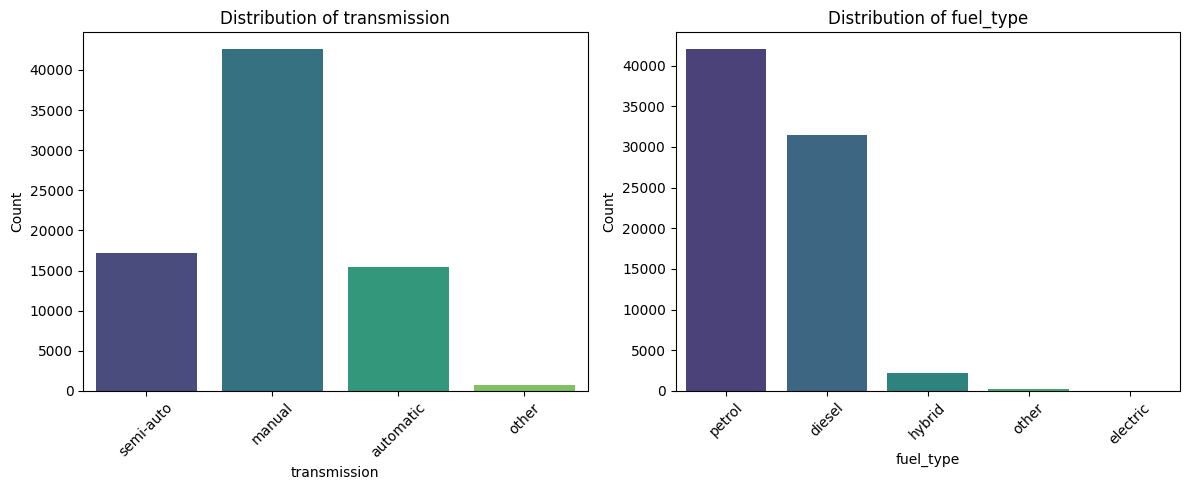

In [323]:
cat_features = ['transmission', 'fuel_type']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


We will set 'other' as NaN values and fill it again with the RFC model.  
For the fuel_type, we will merge the 'hybrid' and 'electric' to 'other' 

---

## **Outliers**

---

## **Feature Engineering**

### **Feature Enrichment**

we have an idea to extract the horsepower and the number of gears from the external dataset. we will do that in the final delivery if so  
https://sesjournal.org/index.php/1/article/view/104/724

### **Feature Selection**

for the feature selection, we will first make an analysis for the categorical classes and check if we have any categorical feature where the average price is more or less the same for every class. After, we will check the correlation heatmap to see if we have any redundant feature and lastly we will perform some feature elimination methods. Based on each steps results, we will decide which features to keep for the model.


C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\2478026143.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


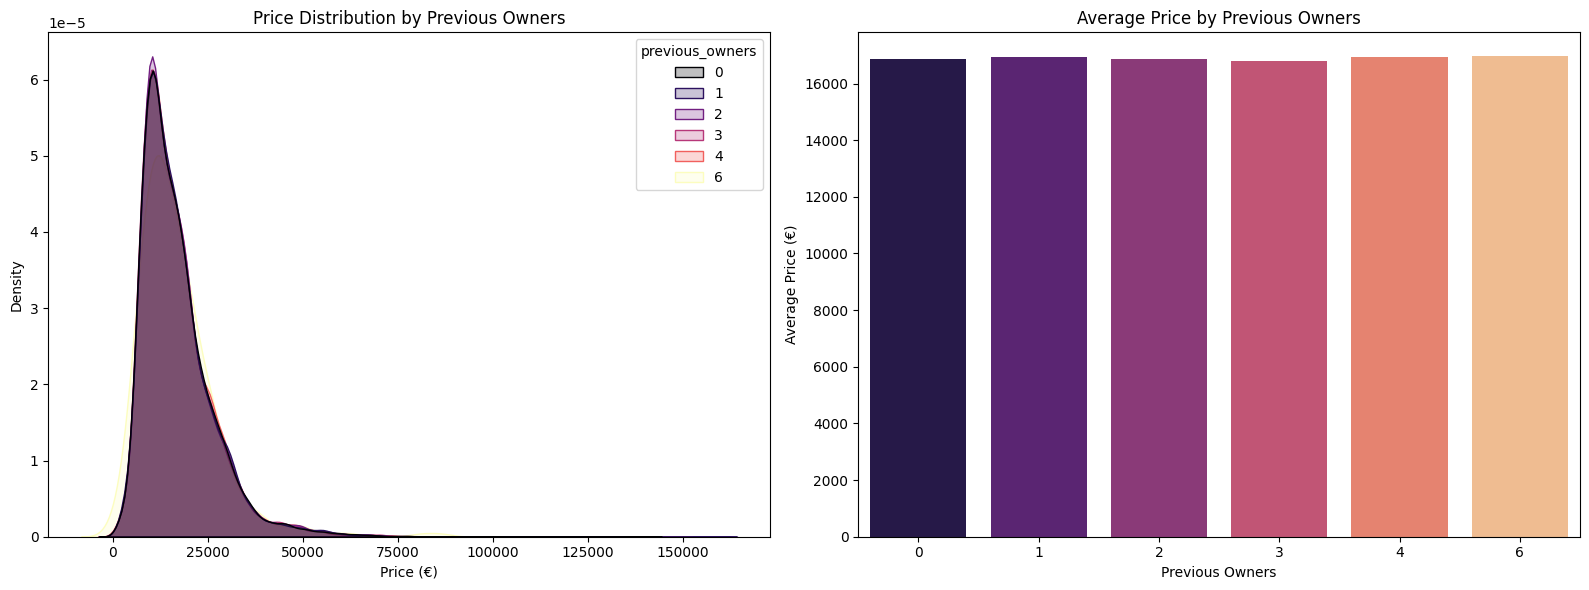

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Left: KDE plot ---
sns.kdeplot(
    data=df,
    x='price',
    hue='previous_owners',
    palette="magma",
    fill=True,
    common_norm=False,
    ax=axes[0]
)
axes[0].set_title("Price Distribution by Previous Owners")
axes[0].set_xlabel("Price (€)")
axes[0].set_ylabel("Density")

# --- Right: Average price bar plot ---
avg_price = df.groupby('previous_owners')['price'].mean().sort_index()
sns.barplot(
    x=avg_price.index,
    y=avg_price.values,
    palette="magma",
    ax=axes[1]
)
axes[1].set_title("Average Price by Previous Owners")
axes[1].set_xlabel("Previous Owners")
axes[1].set_ylabel("Average Price (€)")

plt.tight_layout()
plt.show()

The average price remains almost constant across different numbers of previous owners, indicating that ownership history has little to no direct impact on price.  
For that reason we will probably drop this feature from our df

C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_16996\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=a

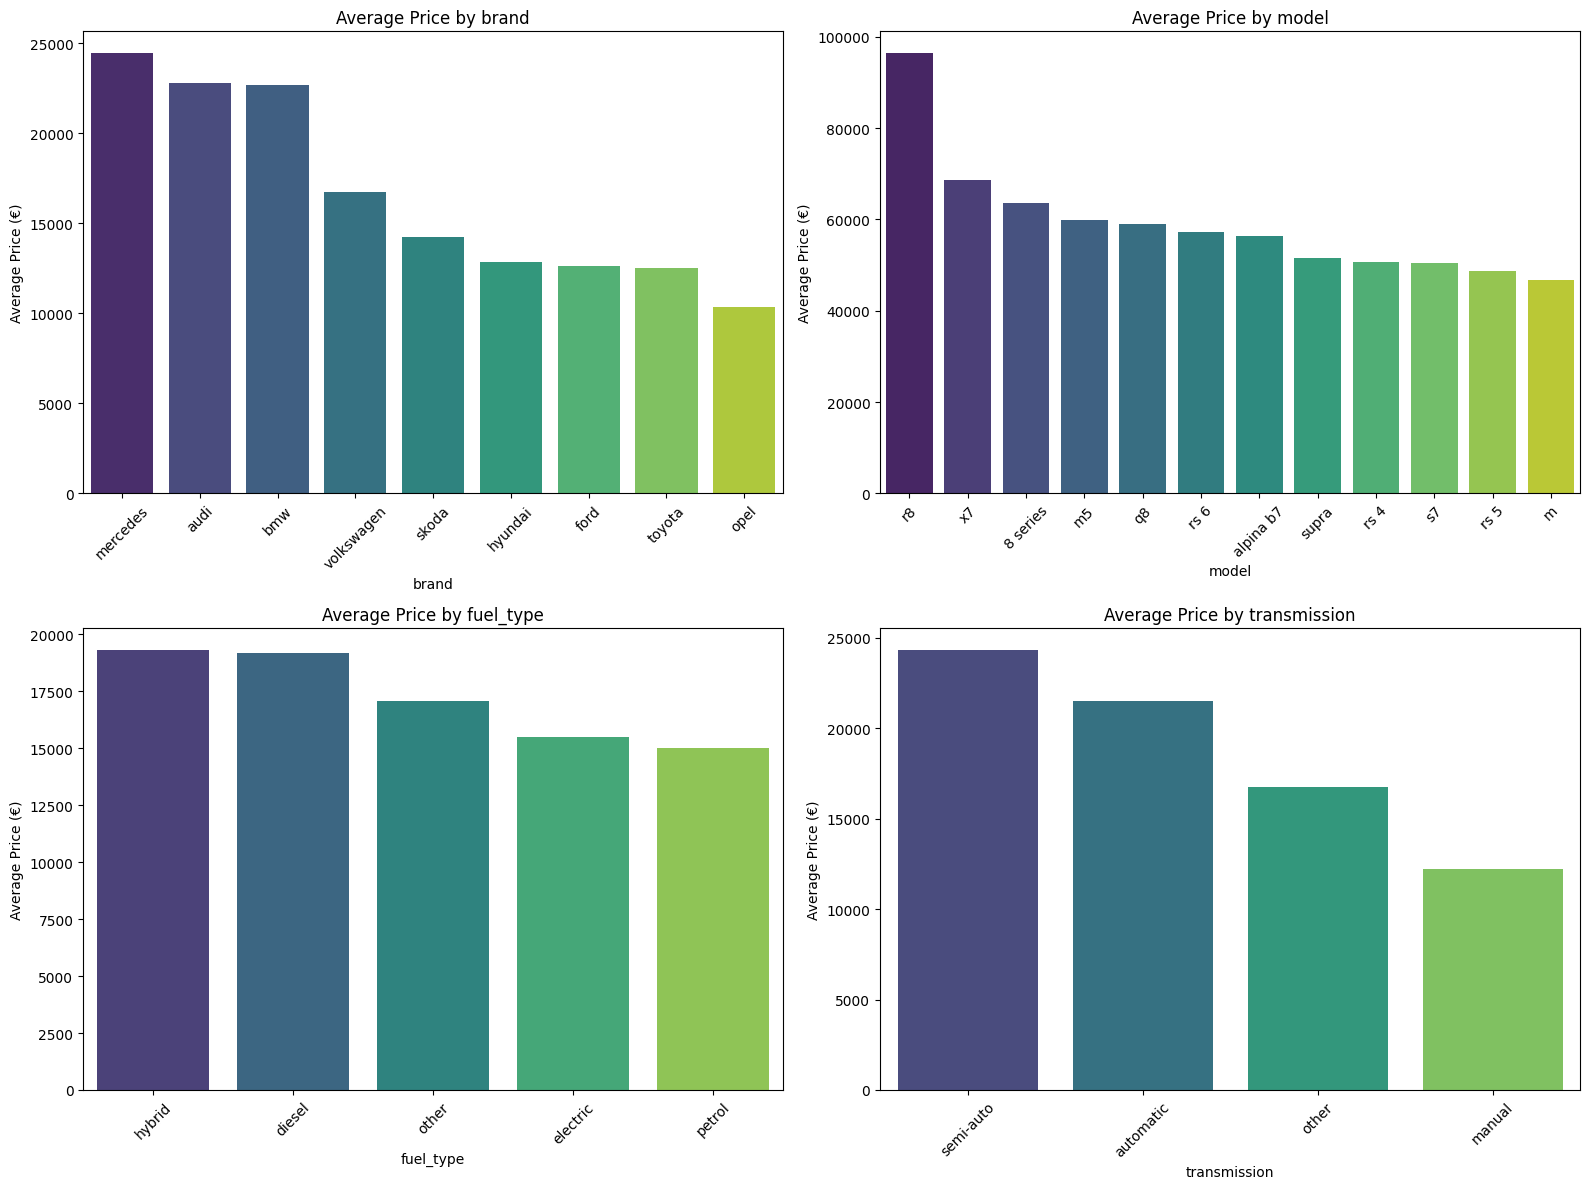

In [230]:
cat_cols = [c for c in ['brand','model','fuel_type','transmission'] if c in df.columns]
TOP_N = 12

fig, axes = plt.subplots(2, 2, figsize=(16,12))  # 2 rows, 2 cols
axes = axes.flatten()  # make it 1D for easy indexing

for i, col in enumerate(cat_cols):
    # Calculate the average price per category and select the top N
    avg_price = df.groupby(col)['price'].mean().sort_values(ascending=False).head(TOP_N)
    
    sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Average Price by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Average Price (€)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

all the other categorical features have a clear impact on the price, since we have some difference in the average price for each category.

#### **Correlation Heatmap**

In [231]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

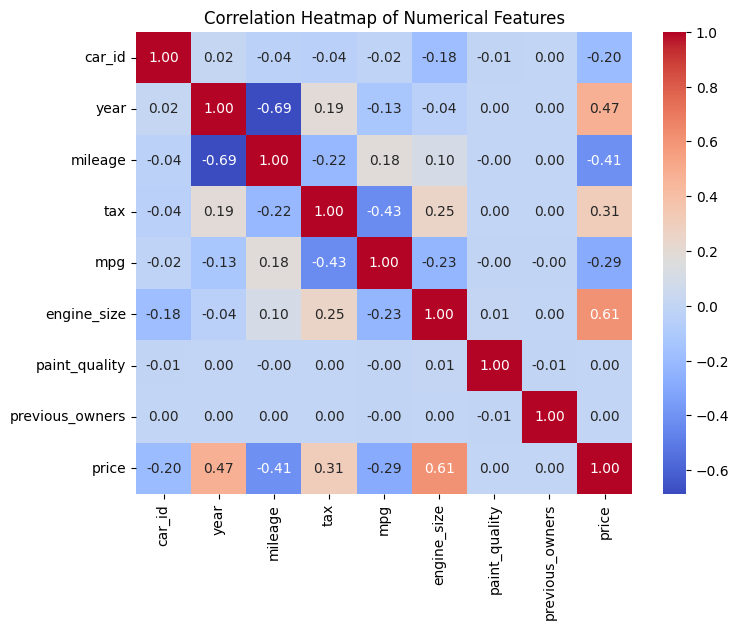

In [232]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

There are no redundant features in the dataset.  
Paint Quality and Previous Owners dont have any correlation with the price, we will probably remove them from the dataset.

#### **feature elimination methods here**

#### **feature manipulation**

as we said earlier, we will merge the 'eletric' and 'hybrid' fuel types to 'other' fuel type, since they are not that common

In [337]:
# merge 'eletric' and 'hybrid' fuel types to 'other' fuel type
df['fuel_type'] = df['fuel_type'].replace(['electric', 'hybrid'], 'other')

we will also turn the year into age of the car, for convenience

In [339]:
# turn year into age of the car using datetime
df['age'] = datetime.now().year - df['year']
df.drop('year', axis=1, inplace=True)

and we will set the 'other' values in transmission to NaN and fill it again with the RFC model.

In [340]:
# set 'other' as NaN values in transmission
df['transmission'] = df['transmission'].replace('other', np.nan)

# fill NaN values in transmission with the RFC model
df= impute_categorical_rfc(df, 'transmission', ignore_cols=['car_id', 'price'])

       mileage     tax    mpg  engine_size  paint_quality  previous_owners  \
0        28421  102.33  11.42          2.0             63                4   
1         4589  145.00  47.90          1.5             50                1   
2         3624  145.00  40.90          1.5             56                4   
3         9102  145.00  65.70          1.0             50                2   
4         1000  145.00  42.80          1.5             97                3   
...        ...     ...    ...          ...            ...              ...   
75968    14480  125.00  53.30          2.0             78                0   
75969    52134  200.00  47.90          2.0             38                2   
75970    11304  145.00  67.00          1.0             57                3   
75971    69072  125.00  60.10          2.0             74                2   
75972    16709  145.00  64.20          1.1             38                1   

       age  brand_bmw  brand_ford  brand_hyundai  ...  model_x7

---

## **Encoding**

**fuel_type (5 categories)** → One-Hot Encoding (OHE)

**brand (9 categories)** → One-Hot Encoding (OHE)

**transmission (4 categories)** → One-Hot Encoding (OHE)

**model (10 + categories)** → Target Encoding with K-Fold (pre defined)

In [341]:
df_encoded = df.copy()

In [342]:
# One-Hot Encoding for brand
brand_dummies = pd.get_dummies(df['brand'], prefix='brand', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, brand_dummies], axis=1)

# One-Hot Encoding for fuel_type
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, fuel_dummies], axis=1)

# One-Hot Encoding for transmission
trans_dummies = pd.get_dummies(df['transmission'], prefix='trans', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, trans_dummies], axis=1)

In [343]:
# Compute average price per brand and model
avg_price_lookup = df.groupby(['brand', 'model'])['price'].mean().reset_index()
avg_price_lookup.rename(columns={'price':'avg_price'}, inplace=True)

# Save to CSV
avg_price_lookup.to_csv('../data/avg_price_brand_model.csv', index=False)

In [344]:
# Read the precomputed averages
avg_price_lookup = pd.read_csv('../data/avg_price_brand_model.csv')

# Merge with the original dataframe
df_encoded = df_encoded.merge(avg_price_lookup, on=['brand','model'], how='left')

In [345]:
df_encoded = df_encoded.drop(columns=['fuel_type', 'brand', 'transmission', 'model'])

In [346]:
df_encoded.head()

,car_id,mileage,tax,mpg,engine_size,paint_quality,previous_owners,price,age,brand_audi,...,brand_skoda,brand_toyota,brand_volkswagen,fuel_diesel,fuel_other,fuel_petrol,trans_automatic,trans_manual,trans_semi-auto,avg_price
0,69512,28421,102.33,11.42,2.0,63,4,22290,9,0,...,0,0,1,0,0,1,0,0,1,16634.202484
1,53000,4589,145.00,47.90,1.5,50,1,13790,6,0,...,0,1,0,0,0,1,0,1,0,10980.028851
2,6366,3624,145.00,40.90,1.5,56,4,24990,6,1,...,0,0,0,0,0,1,0,0,1,23076.238701
3,29021,9102,145.00,65.70,1.0,50,2,12500,7,0,...,0,0,0,0,0,1,0,1,0,10231.419412
4,10062,1000,145.00,42.80,1.5,97,3,22995,6,0,...,0,0,0,0,0,1,0,1,0,19681.153846
